In [4]:
! mkdir data
! ls -al

mkdir: cannot create directory ‘data’: File exists
total 24
drwxr-xr-x 1 root root 4096 Jun 22 04:30 .
drwxr-xr-x 1 root root 4096 Jun 22 04:22 ..
drwxr-xr-x 1 root root 4096 Jun 18 16:14 .config
drwxr-xr-x 2 root root 4096 Jun 22 04:37 data
drwxr-xr-x 2 root root 4096 Jun 22 04:37 model
drwxr-xr-x 1 root root 4096 Jun 18 16:14 sample_data


モデルデータのOriginalの特徴量(X): (112568, 120)
モデルデータの正解ラベルの個数
0    103393
1      9175
Name: TARGET, dtype: int64
モデルデータの欠損値の補完後の特徴量(X_ohe): (112568, 261)
RFECVによるモデルデータの特徴量選択後(X_ohe_selected): (112568, 66)
【RFECVにより特徴量を選択します。】 f1_weighted
0.881 +- 0.0008
★RFECVのスコア：	 0.8800162525923662
パイプラインを実行し、 roc_auc の評価指標でアルゴリズムを選択後、RandomizedSearchCV / GridSearchCVを実行します。
LogisticRegression : roc_auc : 0.7375 +- 0.0068
confusion matrix:
 [[70948 32445]
 [ 3045  6130]] 

classification report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80    103393
           1       0.16      0.67      0.26      9175

    accuracy                           0.68    112568
   macro avg       0.56      0.68      0.53    112568
weighted avg       0.89      0.68      0.76    112568

CURRENT_SCORE: 0.7307058812158551
RandomForestClassifier : roc_auc : 0.6076 +- 0.0055
confusion matrix:
 [[103393      0]
 [  1853   7322]] 

classification report:
              precision    r

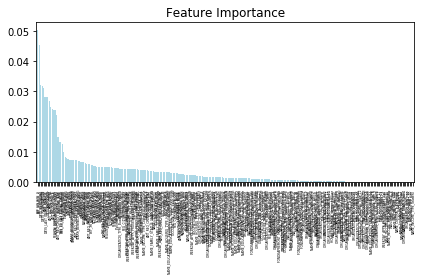

In [5]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning) 

### ご参考 https://qiita.com/msrks/items/e3e958c04a5167575c41

# SET PARAMETERS
file_model = 'application_train.csv'
file_score = 'application_test.csv'

ohe_cols = ['NAME_CONTRACT_TYPE',
            'CODE_GENDER',
            'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'OCCUPATION_TYPE',
            'WEEKDAY_APPR_PROCESS_START',
            'ORGANIZATION_TYPE',
            'FONDKAPREMONT_MODE',
            'HOUSETYPE_MODE',
            'WALLSMATERIAL_MODE',
            'EMERGENCYSTATE_MODE'
            ]

# Chose one of the followings scoreing parameters.
# この解説がわかりやすい: https://blog.amedama.jp/entry/2017/12/18/005311
#                         https://data.gunosy.io/entry/2016/08/05/115345
#SCORE = 'accuracy' # Accuracy = (TP+TN)/(TP+FP+FN+TN)
SCORE = 'roc_auc'  # 偽陽性率と真陽性率で評価する指標
#SCORE = 'precision'# 正と予測したデータのうち，実際に正であるものの割合【正確性】FN を許容し、FP があっては困るとき
#SCORE = 'recall'   # 実際に正であるもののうち，正であると予測された割合【網羅性】[True Positive Rate] FP を許容し、FN があっては困るとき
#SCORE = 'f1'        # 適合率（PRE）と再現率（REC）の調和平均
#SCORE = 'f1_macro' #Macro-F1はクラスサイズを考慮しない
#SCORE = 'f1_micro' #Micro-F1はクラスサイズを考慮する
#SCORE = 'f1_weighted' #Micro-F1はクラスサイズを考慮する。Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
#SCORE = 'recall_weighted'
#SCORE = 'precision_weighted'
#SCORE = 'log_loss'
# ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 
#'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 
#'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 
#'neg_median_absolute_error', 'normalized_mutual_info_score', 
#'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 
#'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
# http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# ハイパーパラメータチューニング時の評価指標
GS_SCORE = 'roc_auc'

# 特徴量選択時の評価指標
# SELECTOR_SCOREに roc_aucを設定すると、all_estimators の実行時にエラーが発生するので注意すること。
SELECTOR_SCORE = 'f1_weighted'

# make dir for modeling file
import os
model_path = './model'
if not os.path.exists(model_path ):
    os.makedirs(model_path )

import matplotlib.pyplot as plt
import time
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,Imputer,MinMaxScaler,RobustScaler,MaxAbsScaler
from sklearn.feature_selection import RFECV, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.externals import joblib
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import scipy.stats as st
from sklearn.utils.testing import all_estimators
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statistics import mean, median,variance,stdev

# data load
#df = pd.read_csv('./data/'+ file_model + '.csv', header=0)
df = pd.read_csv('./data/'+ file_model, header=0)
ID = df.iloc[:,0] 
y = df.iloc[:,1]
X = df.iloc[:,2:]

## TEST
## print(y)
## print(X)

print('モデルデータのOriginalの特徴量(X):', X.shape)
print('モデルデータの正解ラベルの個数')
print(y.value_counts())

# preprocessing-1: one-hot encoding
X_ohe = pd.get_dummies(X, dummy_na=True, columns=ohe_cols)
X_ohe = X_ohe.dropna(axis=1, how='all')
X_ohe_columns = X_ohe.columns.values

# preprocessing-2: null imputation
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_ohe)
X_ohe = pd.DataFrame(imp.transform(X_ohe), columns=X_ohe_columns)
print('モデルデータの欠損値の補完後の特徴量(X_ohe):', X_ohe.shape)

# preprocessing-3: feature selection
# 特徴量選択に関するご参考 https://hayataka2049.hatenablog.jp/entry/2018/01/25/075927
#						   https://www.kaggle.com/narumin/titanic-data-science-japanese-tutorial
#						   https://qiita.com/rockhopper/items/a68ceb3248f2b3a41c89

### 重要度を抽出する################################################################
estimator_rf = RandomForestClassifier(random_state=0)
estimator_rf.fit(X_ohe, y.as_matrix().ravel())
importances = estimator_rf.feature_importances_

indices = np.argsort(importances)[::-1]

feat_labels = X_ohe.columns[0:]
for f in range(X_ohe.shape[1]):
#	print("%2d) %-*s %f" % (f +1,30, feat_labels[indices[f]], importances[indices[f]]))
	IMPORTANCES_LIST = pd.DataFrame([["%2d) %-*s %f" % (f +1, 30, feat_labels[indices[f]], importances[indices[f]])]] )
	IMPORTANCES_LIST.to_csv('./data/' + file_model +'_feature_importances.csv', mode='a', header=False, index=False)

plt.title('Feature Importance')
plt.bar(range(X_ohe.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_ohe.shape[1]), feat_labels[indices], rotation=90, fontsize=3)
plt.xlim([-1, X_ohe.shape[1]])
plt.tight_layout()
#plt.show
plt.savefig('./data/' + file_model + '_feature_importances.png', dpi=1000)
##################################################################################

### RFECVの場合
selector = RFECV(estimator=RandomForestClassifier(random_state=0), step=0.05, cv=3, scoring=SELECTOR_SCORE)
##selector = RFECV(estimator=RandomForestClassifier(random_state=0), step=0.05) ### ORIGINAL 

selector.fit(X_ohe, y.as_matrix().ravel())
X_ohe_selected = selector.transform(X_ohe)
X_ohe_selected = pd.DataFrame(X_ohe_selected, columns=X_ohe_columns[selector.support_])

print('===============================================================================================================')
print('RFECVによるモデルデータの特徴量選択後(X_ohe_selected):',X_ohe_selected.shape)
print('【RFECVにより特徴量を選択します。】',SELECTOR_SCORE)

estimator = RandomForestClassifier(random_state=0)
estimator.fit(X_ohe, y.as_matrix().ravel())

kfold = KFold(n_splits=3, shuffle=True, random_state=1)

rfecv_results = cross_val_score(estimator, X_ohe_selected, y.values.ravel(), scoring=SELECTOR_SCORE, cv=kfold)
RFECV_AVG = mean(rfecv_results) - stdev(rfecv_results)
print(round(np.average(rfecv_results), 4), '+-', round(np.std(rfecv_results), 4))

print('★RFECVのスコア：\t', RFECV_AVG)
print('===============================================================================================================')

#############################################################################################
# preprocessing-4: preprocessing of a score data along with a model dataset
if len(file_score)>0:
    # load score data
    dfs = pd.read_csv('./data/'+ file_score, header=0)
    IDs = dfs.iloc[:,[0]] 
    Xs = dfs.iloc[:,1:]
    Xs_ohe = pd.get_dummies(Xs, dummy_na=True, columns=ohe_cols)
    cols_m = pd.DataFrame(None, columns=X_ohe_columns, dtype=float)

# consistent with columns set
Xs_exp = pd.concat([cols_m, Xs_ohe])
Xs_exp.loc[:,list(set(X_ohe_columns)-set(Xs_ohe.columns.values))] = \
                        Xs_exp.loc[:,list(set(X_ohe_columns)-set(Xs_ohe.columns.values))].fillna(0, axis=1)
Xs_exp = Xs_exp.drop(list(set(Xs_ohe.columns.values)-set(X_ohe_columns)), axis=1)

# re-order the score data columns
Xs_exp = Xs_exp.reindex_axis(X_ohe_columns, axis=1)
Xs_exp = pd.DataFrame(imp.transform(Xs_exp), columns=X_ohe_columns)

Xs_exp_selected = Xs_exp.loc[:,X_ohe_columns[selector.support_]]		# RFECVの場合


# CLASSIFIER
lr = Pipeline([('scl', StandardScaler()),
#              ('mms', MinMaxScaler()),
#              ('mas', MaxAbsScaler()),
#               ('rs', RobustScaler()),
               ('reduct',PCA(svd_solver='auto',random_state=1)),
               ('clf', LogisticRegression(C=10, class_weight='balanced', random_state=1))])

knn = Pipeline([('scl', StandardScaler()),
                ('reduct',PCA(svd_solver='auto',random_state=1)),
                ('clf', KNeighborsClassifier(algorithm='auto', 
                                                leaf_size=30, 
                                                metric='minkowski',
                                                metric_params=None,  
                                                n_neighbors=5, 
                                                p=2,
                                                weights='uniform'))])

svm = Pipeline([('scl', StandardScaler()),
                ('reduct',PCA(svd_solver='auto',random_state=1)),
                ('clf', SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=1))])

dc = Pipeline([('scl', StandardScaler()),
               ('reduct',PCA(svd_solver='auto',random_state=1)),
               ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=1))])

rf = Pipeline([('scl', StandardScaler()),
               ('reduct',PCA(svd_solver='auto',random_state=1)),
               ('clf', RandomForestClassifier(class_weight='balanced', random_state=1))])

rsvc = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',SVC(C=1.0, kernel='rbf', class_weight='balanced', random_state=1))])

lsvc = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',LinearSVC(C=1.0, class_weight='balanced', random_state=1))])

gb1 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',GradientBoostingClassifier(random_state=1))])

gb2 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=1))])

gb3 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=3, random_state=1))])

xgb1 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est', xgb.XGBClassifier(random_state=1))])

xgb2 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est', xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,colsample_bytree=0.8,
                                           gamma=0,max_depth=5,min_child_weight=3, subsample=0.7,objective='binary:logistic',random_state=1))])

xgb3 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est', xgb.XGBClassifier(n_estimators=1000,learning_rate=0.1,colsample_bytree=0.8,
                                           gamma=0,max_depth=5,min_child_weight=3, subsample=0.7,objective='binary:logistic',random_state=1))])
gnb = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',GaussianNB())])

btree = DecisionTreeClassifier(criterion='entropy',max_depth='None',random_state=1)

bag = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
#                 ('est',BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', random_state=1),n_estimators = 100, max_features = 0.5,random_state=1))])
                 ('est',BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', random_state=1),random_state=1))])
#                 ('est',BaggingClassifier(base_estimator=btree, n_estimators=100,max_samples=1.0,max_features=1.0,bootstrap=True,bootstrap_features=False,n_jobs=-1,random_state=1))])

mlp = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
#                 ('est',MLPClassifier(hidden_layer_sizes=(10,5),max_iter=100,random_state=1))])
                 ('est',MLPClassifier(random_state=1))])

clf1 = AdaBoostClassifier(n_estimators=10)
clf2 = ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='gini',max_depth=1)
clf3 = xgb.XGBClassifier(n_estimators=10, nthread=-1, max_depth = 1, seed=1)
clf4 = GradientBoostingClassifier(n_estimators=10)
clf5 = RandomForestClassifier(max_depth = 1,class_weight='balanced', random_state=1)

vot = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',VotingClassifier(estimators=[('ab', clf1), ('etc', clf2), ('xgb', clf3),('gbc', clf4)], weights=[1,1,1,1], voting='soft'))])

vot2 = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',VotingClassifier(estimators=[('ab', clf1), ('etc', clf2), ('xgb', clf3),('gbc', clf4),('gnb', clf5)], weights=[1,1,1,1,1], voting='soft'))])

# RidgeClassifierには、「predict_proba」メソッドがないことが判明。ループから除外する
rc = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',RidgeClassifier(random_state=1))])
                 
lda = Pipeline([('scl',StandardScaler()),
                 ('reduct',PCA(svd_solver='auto',random_state=1)),
                 ('est',LinearDiscriminantAnalysis())])

#models = [lr, knn, svm, dc, rf, rsvc, lsvc, gb1, gb2, gb3, xgb1, xgb2, xgb3, gnb, bgc, mlp]
#models = [lr, knn, svm, dc, rf, rsvc, gb1, gb2, gb3, xgb1, xgb2, xgb3, bag, mlp, vot, rc, lda]
#models = [lr, knn, svm, dc, rf, rsvc, bag, mlp, vot, gb1, gb2, gb3, xgb1, xgb2, xgb3]
#models = [lr, knn, svm, dc, rf, rsvc, bag, gb1, gb2, gb3, xgb1, xgb2, xgb3]
#models = [lr, knn, svm, dc, rf, rsvc, bag, gb1, xgb1, xgb2, xgb3]
models = [lr, rf, bag, gb1, xgb1]

model_names = ['LogisticRegression',
#               'KNeighborsClassifier',
#               'SVM',
#               'DecisionTreeClassifier',
               'RandomForestClassifier',
#               'RSVC',
#               'LinearSVC',
               'BaggingClassifier',
#               'MLPClassifier',
#               'VotingClassifier',
               'GradientBoostingClassifier',
#               'GradientBoostingClassifier',
#               'GradientBoostingClassifier',
               'XGBClassifier',
#               'XGBClassifier',
#               'XGBClassifier'
#               'GaussianNB',
#               'VotingClassifier'
#               'RidgeClassifier',
#               'LinearDiscriminantAnalysis'
              ]

#for loop in range(100):
#    x_train, x_test, y_train, y_test = train_test_split(X_ohe_selected,
#                                                        y.as_matrix().ravel(),
#                                                        test_size=0.2)
#with open('./data/' + 'model_score_list.csv', 'w') as f:
#writer = csv.writer(f, lineterminator='\n') # 改行コード（\n）を指定しておく
#writer.writerows([[round(np.average(results), 4), model_name]]) # 2次元配列も書き込める

print('パイプラインを実行し、',SCORE,'の評価指標でアルゴリズムを選択後、RandomizedSearchCV / GridSearchCVを実行します。')
print('===============================================================================================================')

BEST_SCORE = 0

MODEL_RANKING = pd.DataFrame()
### https://hayataka2049.hatenablog.jp/entry/2018/03/14/112454 #評価指標について
for model_name, model in zip(model_names, models):
    model.fit(X_ohe_selected, y.values.ravel())
#    train_score = model.score(X_ohe_selected, y.values.ravel())
#    test_score = model.score(X_ohe_selected, y.values.ravel())

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    results = cross_val_score(model, X_ohe_selected, y.values.ravel(), scoring=SCORE, cv=kfold)
    
    print(model_name, ':', SCORE, ':', round(np.average(results), 4), '+-', round(np.std(results), 4))    

    ModelCM = confusion_matrix(y.as_matrix().ravel(), model.predict(X_ohe_selected))
    print('confusion matrix:\n', ModelCM, '\n')
    print('classification report:')
    print(classification_report(y.as_matrix().ravel(), model.predict(X_ohe_selected)))
    
    CURRENT_SCORE = np.average(results) - np.std(results)
    print('CURRENT_SCORE:', CURRENT_SCORE)
    
    print('===============================================================================================================')

    MODEL_SCORE_LIST = pd.DataFrame([[model_name, SCORE, round(np.average(results), 4), model]] )
    MODEL_SCORE_LIST.to_csv('./data/' + 'model_score_list.csv', mode='a', header=False, index=False)
    
    if (BEST_SCORE < CURRENT_SCORE ):
        BEST_SCORE = CURRENT_SCORE
        BEST_ALGORITHM = model_name
        BEST_MODEL = model

print('★選択した評価指標におけるBest algorithm: ', BEST_ALGORITHM)
print('Best', SCORE ,'score:', BEST_SCORE, '\n')
#print('Best_model:', BEST_MODEL)

import datetime
now1 = datetime.datetime.now()
#print('test_{0:%Y%m%d%H%M}'.format(now1))
str1 = '{0:%Y%m%d%H%M}'.format(now1)
#print(str1)

joblib.dump(BEST_MODEL, './model/'+ str1 +'_'+ BEST_ALGORITHM + '.pkl')

score = pd.DataFrame(BEST_MODEL.predict_proba(Xs_exp_selected)[:,1], columns=['pred_score'])
IDs.join(score).to_csv('./data/'+ str1 +'_'+ BEST_ALGORITHM + '_' + file_score + '_with_pred.csv', index=False)

print('===============================================================================================================')
print('評価指標:', GS_SCORE, 'アルゴリズム:', BEST_ALGORITHM, 'で GridSearchCV / RamdomizedSearchCVを実行します。')

# xgboost のvoting ensenble
# https://www.kaggle.com/pablonieto/eeg-analysis-voting-ensemble-python-2-7

if BEST_ALGORITHM == 'LogisticRegression' :
#4 x 11 x 2 = 88通り
    GRID_EST = LogisticRegression(class_weight='balanced', random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__C':[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25., 50, 100.],
                  'est__penalty':['l1','l2']
#                  'est__solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                 }
# http://kamonohashiperry.com/archives/209
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb
elif BEST_ALGORITHM == 'XGBClassifier' :
#4 x 3 x 11 x 11 x 3 x 3 x 10 x 10 x 2 = 2613600通り
    one_to_left = st.beta(10, 1)  
    from_zero_positive = st.expon(0, 50)
    GRID_EST = xgb.XGBClassifier(objective='binary:logistic', early_stopping_rounds=30, random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__learning_rate': [0.1, 0.05, 0.01],
                  'est__max_depth': sp_randint(3, 10), #randint(a, b)はa <= n <= bであるランダムな整数nを返す
                  'est__gamma':sp_randint(0, 10),
#                  'est__subsample': one_to_left, 
#                  'est__colsample_bytree': one_to_left,
#                  'est__reg_lambda': sp_randint(1, 10),
                  'est__scale_pos_weight':sp_randint(1, 10), # useful for unbalanced
                  'est__max_delta_step':sp_randint(1, 10), # useful for unbalanced
#                  'est__reg_alpha': from_zero_positive,
                  'est__min_child_weight': from_zero_positive, 
                  'est__n_estimators': [100, 1000]
                 }

elif BEST_ALGORITHM == 'GradientBoostingClassifier' :
# 4 x 4 x 11 x 19 x 20 x 3 x 4 = 802560通り
    GRID_EST = GradientBoostingClassifier(random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
#                  'est__learning_rate': [1e-3, 1e-2, 1e-1, 0.5],
                  'est__learning_rate': [0.1, 0.05, 0.01],
                  'est__max_depth' : [3, 5, 7, None],
                  'est__min_samples_leaf': sp_randint(1, 11),
                  'est__min_samples_split': sp_randint(2, 11),
                  'est__subsample': [0.5, 0.7, 0.9],
                  'est__max_features': [0.1, 0.3, 0.5, 1],
                  'est__n_estimators': [50,100,300,500]
                 }
    
elif BEST_ALGORITHM == 'RandomForestClassifier' :
# 4 x 3 x 3 x 15 x 2 = 1080
    GRID_EST = RandomForestClassifier(class_weight='balanced',random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
#                  'est__criterion' :['gini', 'entropy']
                  'est__max_depth' : [3, 5, 7, None],
                  'est__min_samples_leaf': sp_randint(1, 11),
                  'est__min_samples_split': sp_randint(2, 11),
                  'est__n_estimators': [50,100,300,500]
                 }

elif BEST_ALGORITHM == 'SVM' :
# 3 x 7 x 9 = 189通り
    GRID_EST = SVC(kernel='rbf', C=1.0,probability=True, class_weight='balanced', random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
#                  'est__kernel': ['rbf','sigmoid','linear'], 
                  'est__kernel': ['rbf'], 
#                  'est__class_weight':['None','balanced'],
				  'est__C': [0.001, 0.01, 0.5, 0.1, 1,10, 50,100, 500,1000],
                  'est__gamma': [1e-5,1e-4,0.001, 0.01, 0.1, 1,10,100,1000]
                 }
elif BEST_ALGORITHM == 'SVC' : 
# 4 x 3 x 7 x 9 = 189通り
    GRID_EST = SVC(probability=True, random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
#                  'est__kernel': ['rbf','sigmoid','linear'], 
                  'est__kernel': ['rbf'], 
#                  'est__class_weight':['None','balanced'],
                  'est__gamma': [1e-5,1e-4,0.001, 0.01, 0.1, 1,10,100,1000],
                  'est__C': [0.001, 0.01, 0.1, 1,10,100,1000]
                 }
elif BEST_ALGORITHM == 'RSVC' :
    GRID_EST = SVC(C=1.0, kernel='rbf', random_state=1,probability=True)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__kernel': ['rbf'], 
#                  'est__class_weight':['None','balanced'],
                  'est__C': [0.001, 0.01, 0.1, 1,10,100,1000],
                  'est__gamma': [1e-5,1e-4,0.001, 0.01, 0.1, 1,10,100,1000]
                 }

elif (BEST_ALGORITHM == 'MLPClassifier'):
    GRID_EST = MLPClassifier(random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__hidden_layer_sizes':[(10,10),(100,10),(200,10),(500,10),(100,20),(200,20),(500,20)],
                  'est__max_iter':[10, 100, 1000],
                  'est__batch_size':[10,50,100],
                  'est__learning_rate': ["constant", "invscaling", "adaptive"],
                  'est__early_stopping':[True],
#                  'est__alpha': [10.0 ** -np.arange(1, 7)],
#                  'est__activation': ["logistic", "relu", "Tanh"]
                 }
elif (BEST_ALGORITHM == 'KNeighborsClassifier'):
    GRID_EST = KNeighborsClassifier(algorithm='auto', 
                                                leaf_size=30, 
                                                metric='minkowski',
                                                metric_params=None,  
                                                n_neighbors=5, 
                                                p=2,
                                                weights='uniform')
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__n_neighbors': [1,2,3,4,5,6,7,8,9,10]
                 }
elif (BEST_ALGORITHM == 'DecisionTreeClassifier'):
    GRID_EST = DecisionTreeClassifier(class_weight='balanced', random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__max_depth': [1,2,3,4,5,6,7,8,9,10],
                  'est__criterion': ['gini', 'entropy']
                 }

elif (BEST_ALGORITHM == 'BaggingClassifier'):
#dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
    GRID_EST = BaggingClassifier(DecisionTreeClassifier(),n_estimators = 100)
#    GRID_EST = BaggingClassifier(DecisionTreeClassifier(),n_estimators = 100, max_features = 0.5)
#    GRID_EST = BaggingClassifier(base_estimator=btree, n_estimators=100,max_samples=1.0, max_features=1.0,bootstrap=True,bootstrap_features=False,n_jobs=-1,random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None]
#                  'est__bootstrap_features': [False, True],
#                  'est__max_features': [0.5, 0.7, 1.0],
#                  'est__max_samples': [0.5, 0.7, 1.0]
                 }
elif (BEST_ALGORITHM == 'VotingClassifier'):
    GRID_EST = VotingClassifier(estimators=[('ab', clf1), ('etc', clf2), ('xgb', clf3),('gbc', clf4)], weights=[1,1,1,1], voting='soft')
    # Voting のgridsearchの例
    # https://qiita.com/yagays/items/a503117bd06bb938fdb9
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None]
                 }

elif (BEST_ALGORITHM == 'RidgeClassifier'):
    GRID_EST = RidgeClassifier(random_state=1)
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None],
                  'est__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
                 }
elif (BEST_ALGORITHM == 'LinearDiscriminantAnalysis'):
    GRID_EST = LinearDiscriminantAnalysis()
    GRID_PARAM = {'pca__n_components':[round(len(X_ohe_selected.columns)*0.3),
                                       round(len(X_ohe_selected.columns)*0.5),
                                       round(len(X_ohe_selected.columns)*0.7),
                                       None]
                 }

GRID_PIPE = Pipeline([('scl', StandardScaler()),
                      ('pca', PCA(random_state=1)),
                      ('est', GRID_EST)])

# https://qiita.com/ragAgar/items/2f6bebdba5f9d7381310 # ランダムサーチの例について

#	kfold = KFold(n_splits=10, shuffle=True, random_state=1)
#	StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

#fit_params = {"early_stopping_rounds": 3000,
#              "eval_set": [[X_ohe_selected, y.as_matrix().ravel()]]}

if BEST_ALGORITHM == 'XGBClassifier':
	gs= RandomizedSearchCV( estimator=GRID_PIPE,
                            param_distributions=GRID_PARAM,
#                            fit_params=fit_params,
#                            cv=3,                 #CV
                            cv=KFold(n_splits=3, shuffle=True, random_state=1),                 #CV
                            n_iter=200,           #interation num
                            scoring=GS_SCORE,     #metrics
                            random_state=1)

elif BEST_ALGORITHM == 'GradientBoostingClassifier' or BEST_ALGORITHM == 'RandomForestClassifier' :
	gs= RandomizedSearchCV( estimator=GRID_PIPE,
                            param_distributions=GRID_PARAM,
#                            cv=3,                 #CV
                            cv=KFold(n_splits=3, shuffle=True, random_state=1),                 #CV
                            n_iter=200,           #interation num
                            scoring=GS_SCORE,     #metrics
                            random_state=1)

else:
	# GridSearchCVのパイプラインの設定
	gs = GridSearchCV(estimator=GRID_PIPE,
	                  param_grid=GRID_PARAM,
	                  scoring=GS_SCORE,
#	                  cv=3
                      cv=KFold(n_splits=3, shuffle=True, random_state=1)
	                  )

start = time.time()
gs = gs.fit(X_ohe_selected, y.as_matrix().ravel())

# 探索した結果のベストスコアとパラメータの取得
print('★GS Best Score:',gs.best_score_)
print('★GS Best Params:', gs.best_params_)
print('GS Best Estimator:',gs.best_estimator_)

end   = time.time()
#print(start)
#print(end)
print('GridSearch 実行時間:',round((end - start)/60, 1), '分')

#print('===============================================================================================================')
#print('nested cross-validation のスコア')
#start2 = time.time()
#nested_cv_scores = cross_val_score(gs,
#                            X_ohe_selected,
#                            y.as_matrix().ravel(),
#                            scoring=GS_SCORE,
#                            cv=5
#                            )
#
#print(BEST_ALGORITHM, ':\t', SCORE, ':', round(np.average(nested_cv_scores), 4), '+-', round(np.std(nested_cv_scores), 4))
#end2   = time.time()
#print('Nested cross-validation 実行時間:',round((end2 - start2)/60, 1), '分')

# classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2)
# y_true : 1d array-like, or label indicator array / sparse matrix /Ground truth (correct) target values.
# y_pred : 1d array-like, or label indicator array / sparse matrix /Estimated targets as returned by a classifier.

import datetime
now = datetime.datetime.now()
#print('test_{0:%Y%m%d%H%M}'.format(now))

if gs.best_score_ >= BEST_SCORE :
	print('===============================================================================================================')
	print('GridSearch / RandamizedSearch のベストモデルでスコアデータの予測をします。')
	CM = confusion_matrix(y.as_matrix().ravel(), gs.predict(X_ohe_selected))
	print('confusion matrix:\n', CM)
	print(classification_report(y.as_matrix().ravel(), gs.predict(X_ohe_selected)))

	GS_SCORE_LIST = pd.DataFrame([[GRID_EST, GS_SCORE, gs.best_score_, gs.best_params_]] )
	GS_SCORE_LIST.to_csv('./data/' + 'grid_score_list.csv', mode='a', header=False, index=False)
	
	now2 = datetime.datetime.now()
	#print('test_{0:%Y%m%d%H%M}'.format(now2))
	str2 = '{0:%Y%m%d%H%M}'.format(now2)
	joblib.dump(gs, './model/'+ str2 + '_'+ BEST_ALGORITHM + '.pkl')


	#保存したモデルをロード
#	filename=BEST_ALGORITHM + '.pkl'	
#	print(BEST_ALGORITHM,'.pkl を保存しました。')
#	loaded_model = joblib.load(open('./model/'+ filename, 'rb'))

	score = pd.DataFrame(gs.predict_proba(Xs_exp_selected)[:,1], columns=['pred_score'])
	IDs.join(score).to_csv('./data/'+ str2 + '_' + BEST_ALGORITHM + '_' + file_score + '_with_pred.csv', index=False)
	print('処理が終了しました。')
	print('===============================================================================================================')

elif gs.best_score_ < BEST_SCORE :
	print('===============================================================================================================')
	print('GridSearch / RandamizedSearchの探索結果がいまいちだったみたいです・・・')

	print('===============================================================================================================')

#cv_result.csvを格納
#pd.DataFrame(gs.cv_results_).to_csv('./data/'+  model_name + '_' + file_score + 'cv_result.csv', index=False)
#AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### optuna
#http://www.algo-fx-blog.com/xgboost-optuna-hyperparameter-tuning/
